In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soccer-shoe-data/train_data/prompt.csv
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image233.jpg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image202.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image146.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image111.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image203.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image91.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image144.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image105.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image96.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image166.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image241.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image161.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoes/image234.jpeg
/kaggle/input/soccer-shoe-data/train_data/soccer_shoe

In [2]:
import os
import math
from glob import glob
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms

from diffusers import (
    StableDiffusionPipeline,
    DPMSolverMultistepScheduler,
    AutoencoderKL,
    UNet2DConditionModel
)

from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from datasets import load_dataset

from peft import LoraConfig, get_peft_model

2025-05-24 01:44:47.546026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748051087.736002      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748051087.786405      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class Config:
    # Tên mô hình Stable Diffusion cơ sở
    pretrained_model_name = "stabilityai/stable-diffusion-2-1" 
    # Đường dẫn tới dataset
    dataset_path = "/kaggle/input/soccer-shoe-data/train_data/soccer_shoes"  
    csv_path =  "/kaggle/input/soccer-shoe-data/train_data/prompt.csv"
    # Thư mục lưu kết quả training
    output_dir = "/kaggle/working/lora_output"  
    
    # Kích thước ảnh đầu vào (giảm xuống để tiết kiệm VRAM)
    resolution = 256
    
    # Các thông số training được tối ưu cho Colab free
    train_batch_size = 1  # Batch size nhỏ để tiết kiệm VRAM
    num_train_epochs = 10  # Giảm số epochs
    learning_rate = 5e-6
    lora_rank = 8  # Rank thấp để tiết kiệm VRAM
    max_grad_norm = 1.0
    mixed_precision = "fp16"  # Sử dụng mixed precision
    
    # Thêm các thông số mới
    gradient_accumulation_steps = 8  # Tích lũy gradient để mô phỏng batch size lớn hơn
    save_steps = 100  # Lưu checkpoint thường xuyên hơn
        
    # Tối ưu hóa bộ nhớ
    enable_attention_slicing = True
    enable_vae_slicing = True
    

config = Config()

In [4]:
class CarAdvertisementDataset(Dataset):
    def __init__(self, dataset_path, csv_path, tokenizer, resolution=256, min_caption_length=10, min_image_size=128):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.tokenizer = tokenizer
        self.resolution = resolution
        self.min_caption_length = min_caption_length
        self.min_image_size = min_image_size

        self.df = pd.read_csv(csv_path)
        print(f"Total rows in CSV: {len(self.df)}")

        self.valid_pairs = []
        for idx, row in self.df.iterrows():
            img_name = row['images']
            caption = row['prompt']
            img_path = os.path.join(dataset_path, img_name)

            if not os.path.exists(img_path):
                continue

            if len(str(caption).split()) < self.min_caption_length:
                continue

            try:
                image = Image.open(img_path).convert("RGB")
                width, height = image.size
                if width < self.min_image_size or height < self.min_image_size:
                    continue
            except Exception as e:
                print(f"Skipping {img_path}: {str(e)}")
                continue

            self.valid_pairs.append((img_path, caption))

        self.valid_pairs = self.valid_pairs[:200]
        print(f"Found {len(self.valid_pairs)} valid image-caption pairs")

        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Pad(
                padding=0,  # Will compute padding dynamically if needed
                fill=0,     # Fill with black pixels (or adjust as needed)
                padding_mode='constant'  # Use constant value for padding
            ),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        try:
            image_path, caption = self.valid_pairs[idx]
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            tokens = self.tokenizer(
                caption,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            )
            return {
                "pixel_values": image,
                "input_ids": tokens.input_ids[0],
                "attention_mask": tokens.attention_mask[0]
            }
        except Exception as e:
            print(f"Error loading item {idx}: {str(e)}")
            new_idx = random.randint(0, len(self.valid_pairs) - 1)
            return self.__getitem__(new_idx)

In [5]:
def main():
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision
    )
    device = accelerator.device

    tokenizer = CLIPTokenizer.from_pretrained(config.pretrained_model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(config.pretrained_model_name, subfolder="text_encoder").to("cpu")
    vae = AutoencoderKL.from_pretrained(config.pretrained_model_name, subfolder="vae").to("cpu")
    if config.enable_vae_slicing:
        vae.enable_slicing()

    unet = UNet2DConditionModel.from_pretrained(config.pretrained_model_name, subfolder="unet").to(device)
    unet.enable_gradient_checkpointing()
    if config.enable_attention_slicing:
        unet.set_attention_slice("auto")

    lora_config = LoraConfig(
        r=config.lora_rank,
        lora_alpha=config.lora_rank * 2,
        target_modules=["to_q", "to_k", "to_v", "to_out.0"],
        lora_dropout=0.1,
        bias="none"
    )
    unet = get_peft_model(unet, lora_config).to(device)

    noise_scheduler = DPMSolverMultistepScheduler.from_pretrained(config.pretrained_model_name, subfolder="scheduler")

    dataset = CarAdvertisementDataset(
        dataset_path=config.dataset_path,
        csv_path=config.csv_path,
        tokenizer=tokenizer,
        resolution=config.resolution,
        min_caption_length=10,
        min_image_size=128
    )
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

    optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    losses = []
    global_step = 0
    for epoch in range(config.num_train_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to("cpu")).latent_dist.sample().to(device)
                    latents = latents * 0.18215

                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                encoder_hidden_states = text_encoder(batch["input_ids"].to("cpu"))[0].to(device)

                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), config.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

                global_step += 1
                losses.append(loss.item())
                progress_bar.update(1)
                # Removed: progress_bar.set_postfix(loss=loss.item())

                if global_step % config.save_steps == 0 and accelerator.is_local_main_process:
                    unet.save_pretrained(os.path.join(config.output_dir, f"checkpoint-{epoch}-{step}"))

    if accelerator.is_local_main_process:
        final_checkpoint_dir = os.path.join(config.output_dir, "final_model")
        unet.save_pretrained(final_checkpoint_dir)
        print(f"Final model saved at: {final_checkpoint_dir}")

In [6]:
if __name__ == "__main__":
    os.makedirs(config.output_dir, exist_ok=True)
    main()

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Total rows in CSV: 200
Found 200 valid image-caption pairs


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Final model saved at: /kaggle/working/lora_output/final_model


# IMAGE 1

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh đã được lưu tại: /kaggle/working/generated_image_giay1.png


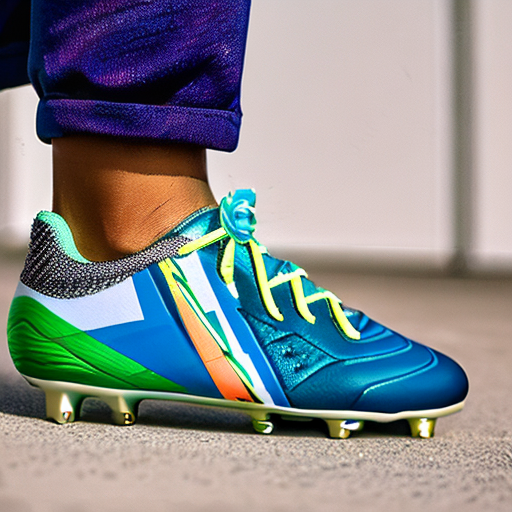

In [7]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import PeftModel
import os
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
output_dir = "/kaggle/working/lora_output"
checkpoint_name = "final_model"  # Dùng mô hình cuối cùng
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "a striking soccer cleat with a teal base, adorned with a purple and white zigzag pattern. It features green sole accents and a green swoosh logo, blending modern style with high-performance functionality for the field."


# Tạo pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name,
    subfolder="unet",
    torch_dtype=torch.float16
)
unet = PeftModel.from_pretrained(unet, os.path.join(output_dir, checkpoint_name))
pipeline.unet = unet
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    num_inference_steps=500,
    guidance_scale=5.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_giay1.png"
image.save(output_image_path)
print(f"Ảnh đã được lưu tại: {output_image_path}")
Image(output_image_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh từ mô hình cơ sở đã được lưu tại: /kaggle/working/generated_image_base1.png


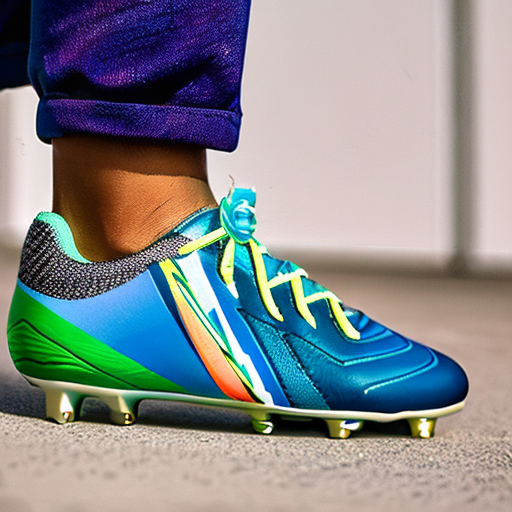

In [8]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "a striking soccer cleat with a teal base, adorned with a purple and white zigzag pattern. It features green sole accents and a green swoosh logo, blending modern style with high-performance functionality for the field."

# Tạo pipeline cơ sở (không áp dụng LoRA)
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    num_inference_steps=500,
    guidance_scale=5.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_base1.png"
image.save(output_image_path)
print(f"Ảnh từ mô hình cơ sở đã được lưu tại: {output_image_path}")
Image(output_image_path)

# IMAGE 2

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh đã được lưu tại: /kaggle/working/generated_image_giay2.png


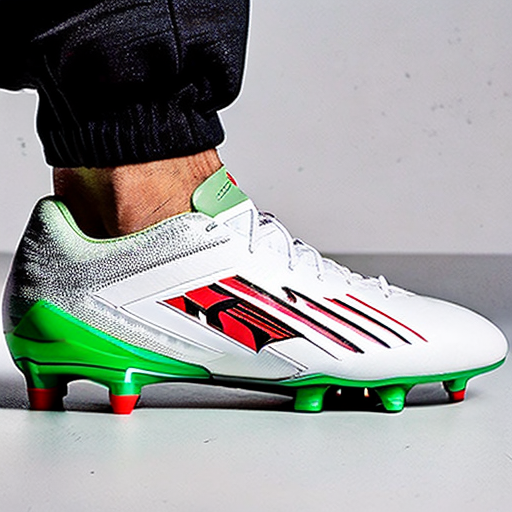

In [11]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import PeftModel
import os
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
output_dir = "/kaggle/working/lora_output"
checkpoint_name = "final_model"  # Dùng mô hình cuối cùng
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "a white soccer cleat from BigSport, labeled (Velocidad Legend), featuring red accents and a sleek design with a green-tinted sole. The price is listed as 599,000 VND, with text indicating it includes free shipping."
negative_prompt = "low quality, blurry, distorted, extra limbs, unrealistic, oversaturated, low detail, cartoonish, watermark"

# Tạo pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name,
    subfolder="unet",
    torch_dtype=torch.float16
)
unet = PeftModel.from_pretrained(unet, os.path.join(output_dir, checkpoint_name))
pipeline.unet = unet
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=500,
    guidance_scale=10.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_giay2.png"
image.save(output_image_path)
print(f"Ảnh đã được lưu tại: {output_image_path}")
Image(output_image_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh từ mô hình cơ sở đã được lưu tại: /kaggle/working/generated_image_base2.png


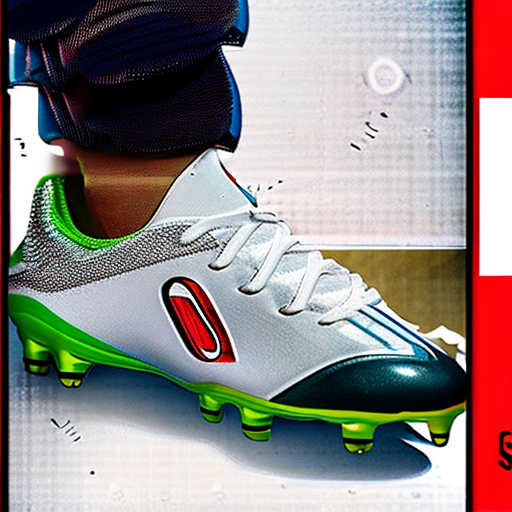

In [12]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "a white soccer cleat from BigSport, labeled (Velocidad Legend), featuring red accents and a sleek design with a green-tinted sole. The price is listed as 599,000 VND, with text indicating it includes free shipping."

# Tạo pipeline cơ sở (không áp dụng LoRA)
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    num_inference_steps=500,
    guidance_scale=5.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_base2.png"
image.save(output_image_path)
print(f"Ảnh từ mô hình cơ sở đã được lưu tại: {output_image_path}")
Image(output_image_path)

# IMAGE 3

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh đã được lưu tại: /kaggle/working/generated_image_giay3.png


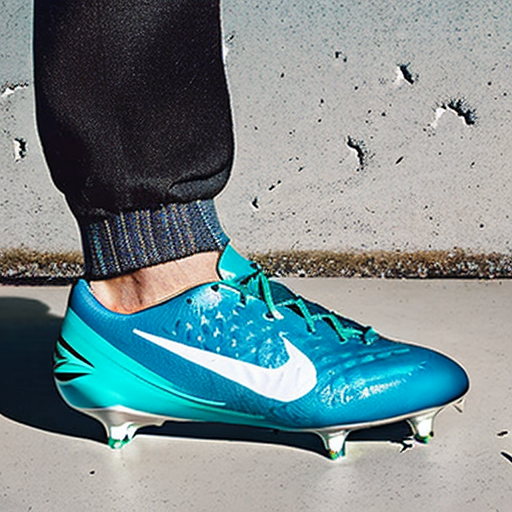

In [13]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import PeftModel
import os
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
output_dir = "/kaggle/working/lora_output"
checkpoint_name = "final_model"  # Dùng mô hình cuối cùng
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "a dynamic Nike advertisement featuring a turquoise soccer cleat with a cracked ground beneath it, symbolizing strength and impact."


# Tạo pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name,
    subfolder="unet",
    torch_dtype=torch.float16
)
unet = PeftModel.from_pretrained(unet, os.path.join(output_dir, checkpoint_name))
pipeline.unet = unet
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    num_inference_steps=500,
    guidance_scale=10.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_giay3.png"
image.save(output_image_path)
print(f"Ảnh đã được lưu tại: {output_image_path}")
Image(output_image_path)

In [15]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "a dynamic Nike advertisement featuring a turquoise soccer cleat with a cracked ground beneath it, symbolizing strength and impact."

# Tạo pipeline cơ sở (không áp dụng LoRA)
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    num_inference_steps=500,
    guidance_scale=10.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_base3.png"
image.save(output_image_path)
print(f"Ảnh từ mô hình cơ sở đã được lưu tại: {output_image_path}")
Image(output_image_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh từ mô hình cơ sở đã được lưu tại: /kaggle/working/generated_image_base3.png


# IMAGE 4

In [17]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import PeftModel
import os
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
output_dir = "/kaggle/working/lora_output"
checkpoint_name = "final_model"  # Dùng mô hình cuối cùng
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "A turquoise soccer cleat with a sleek, modern design, featuring a textured upper with subtle white accents, a reinforced ankle collar, and a sturdy black sole with sharp, visible studs for enhanced grip and impact. no legs"
negative_prompt = "low quality, blurry, distorted, extra limbs, unrealistic, oversaturated, low detail, cartoonish, watermark"

# Tạo pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name,
    subfolder="unet",
    torch_dtype=torch.float16
)
unet = PeftModel.from_pretrained(unet, os.path.join(output_dir, checkpoint_name))
pipeline.unet = unet
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=500,
    guidance_scale=10.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_giay4.png"
image.save(output_image_path)
print(f"Ảnh đã được lưu tại: {output_image_path}")
Image(output_image_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh đã được lưu tại: /kaggle/working/generated_image_giay4.png


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ảnh từ mô hình cơ sở đã được lưu tại: /kaggle/working/generated_image_base4.png


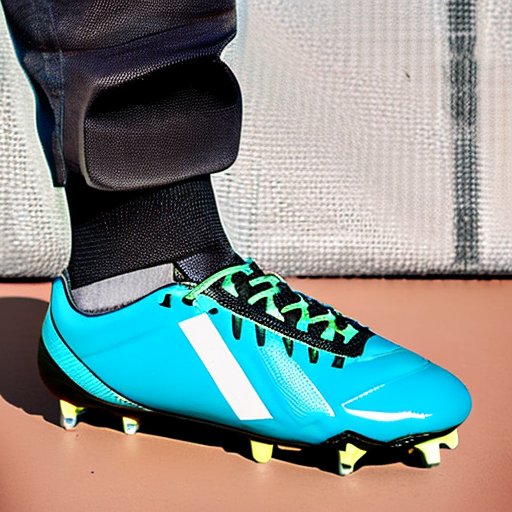

In [18]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import Image

# Tham số
pretrained_model_name = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "A turquoise soccer cleat with a sleek, modern design, featuring a textured upper with subtle white accents, a reinforced ankle collar, and a sturdy black sole with sharp, visible studs for enhanced grip and impact."

# Tạo pipeline cơ sở (không áp dụng LoRA)
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16
)
pipeline = pipeline.to(device)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()

# Tạo ảnh
image = pipeline(
    prompt=prompt,
    num_inference_steps=500,
    guidance_scale=10.0,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
).images[0]

# Lưu và hiển thị
output_image_path = "/kaggle/working/generated_image_base4.png"
image.save(output_image_path)
print(f"Ảnh từ mô hình cơ sở đã được lưu tại: {output_image_path}")
Image(output_image_path)